In [1]:
import pandas as pd
import numpy as np
import os
import sys
import math
import seaborn as sns
from matplotlib import pyplot as plt
import umap.umap_ as umap
import scipy.stats as stats
from tribus import run_tribus, heatmap_for_median_expression, marker_expression, umap_vis, z_score, cell_type_distribution
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import rand_score, accuracy_score, precision_score, f1_score, adjusted_rand_score
from scipy.stats import norm

# Analysis on B004 colon region (CL) - 2nd level

In [2]:
sample_data = pd.read_csv('C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\STELLAR\\input_data\\STELLAR_data_donor_004_upperlevel_CL.csv',low_memory=False)
print("Data dimension is {}".format(np.shape(sample_data)))

#  perform always outlier truncation, set the maximum to the 99.9 percentile
cols = ['MUC2', 'SOX9', 'MUC1', 'CD31', 'Synapto', 'CD49f', 'CD15',
       'CHGA', 'CDX2', 'ITLN1', 'CD4', 'CD127', 'Vimentin', 'HLADR',
       'CD8', 'CD11c', 'CD44', 'CD16', 'BCL2', 'CD3', 'CD123', 'CD38',
       'CD90', 'aSMA', 'CD21', 'NKG2D', 'CD66', 'CD57', 'CD206', 'CD68',
       'CD34', 'aDef5', 'CD7', 'CD36', 'CD138', 'CD45RO', 'Cytokeratin',
       'CK7', 'CD117', 'CD19', 'Podoplanin', 'CD45', 'CD56', 'CD69',
       'Ki67', 'CD49a', 'CD163', 'CD161']

Q = sample_data[cols].quantile(0.999)
sample_data = sample_data[~((sample_data[cols] > Q)).any(axis=1)]
print("Removing the outliers. Current data dimension is {}".format(np.shape(sample_data)))
sample_data[cols].describe()

Data dimension is (110633, 56)
Removing the outliers. Current data dimension is (106284, 56)


,MUC2,SOX9,MUC1,CD31,Synapto,CD49f,CD15,CHGA,CDX2,ITLN1,...,CD117,CD19,Podoplanin,CD45,CD56,CD69,Ki67,CD49a,CD163,CD161
count,106284.000000,106284.000000,106284.000000,106284.000000,106284.000000,106284.000000,106284.000000,106284.000000,106284.000000,106284.000000,...,106284.000000,106284.000000,106284.000000,106284.000000,106284.000000,106284.000000,106284.000000,106284.000000,106284.000000,106284.000000
mean,0.018934,0.038266,-0.004457,-0.009820,-0.028353,-0.011265,-0.008890,-0.036611,-0.057418,-0.006119,...,-0.071547,-0.068401,-0.070777,-0.032676,-0.062574,-0.073321,-0.047083,-0.053539,-0.029241,-0.081616
std,0.914082,0.984921,0.887696,0.933128,0.696530,0.937749,0.712971,0.346951,0.380162,0.835283,...,0.356540,0.275826,0.626899,0.917172,0.608046,0.609828,0.673861,0.895300,0.870577,0.149154
min,-0.304221,-0.615595,-0.587612,-0.247549,-0.266702,-0.664865,-0.299039,-0.121470,-0.377534,-0.450804,...,-0.229015,-0.176098,-0.348490,-0.551046,-0.306917,-0.384767,-0.328653,-0.736535,-0.329448,-0.201729
25%,-0.304218,-0.521452,-0.479456,-0.242406,-0.253885,-0.630530,-0.299028,-0.116135,-0.296667,-0.427149,...,-0.220684,-0.174903,-0.323102,-0.549868,-0.274469,-0.372331,-0.272780,-0.584861,-0.314441,-0.180588
50%,-0.302093,-0.355014,-0.362514,-0.235678,-0.204556,-0.510146,-0.289234,-0.088412,-0.184232,-0.327824,...,-0.183918,-0.163973,-0.263523,-0.510200,-0.220518,-0.315779,-0.198523,-0.374125,-0.286509,-0.137325
75%,-0.183386,0.153371,0.072407,-0.181261,-0.059429,0.327718,-0.059975,-0.041563,0.035428,0.007167,...,-0.063341,-0.104564,-0.080356,0.099011,-0.098664,-0.073942,-0.046464,0.051628,-0.164172,-0.039977
max,11.549352,7.490062,8.260476,10.404527,15.325635,5.779878,12.461669,11.155820,3.384302,7.423312,...,5.778162,3.118132,11.054996,6.050057,8.355805,6.205881,12.600368,5.761102,10.761521,1.147414


In [22]:
# read logic table
df = pd.ExcelFile("C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\STELLAR\\stellar_logic_gate_cl_minisom.xlsx")
logic = pd.read_excel(df, df.sheet_names, index_col=0)

# Run Tribus

In [23]:
depth = 2
labels, scores = run_tribus(sample_data, logic, depth=depth, normalization=z_score, tuning=True, max_evals=15, sigma=1.5, learning_rate=.5, 
                            clustering_threshold=5000, undefined_threshold=0.001, other_threshold=0.1, random_state=42)

Global, subsetting done
x is 40
Current quantization error is 3.6796964892546358        
100%|██████████| 1/True [00:02<00:00,  2.15s/trial, best loss: 3.6796964892546358]
best: {'learning_rate': 2.131520776211636, 'sig': 2.4979258637716026}
Current grid size x is 40, grid size y is 40, sigma is 2.4979258637716026, learning rate is 2.131520776211636.
 [ 500 / 500 ] 100% - 0:00:00 left 
 quantization error: 3.3014325057125387
Myeloid, subsetting done
x is 20
Current quantization error is 3.815378735682113         
100%|██████████| 1/True [00:00<00:00, 21.32trial/s, best loss: 3.815378735682113]
best: {'learning_rate': 0.0685000119723203, 'sig': 3.9365962129881567}
Current grid size x is 20, grid size y is 20, sigma is 3.9365962129881567, learning rate is 0.0685000119723203.
 [ 500 / 500 ] 100% - 0:00:00 left 
 quantization error: 3.539925791548485
Lymphoid, subsetting done
x is 26
Current quantization error is 3.904788844877817         
100%|██████████| 1/True [00:00<00:00,  5.18trial/s

# Visualize the result

In [24]:
# Define the visualization functions
def cell_num_compare(true_label, pred_label): 
    # Plot barplots that show cell numbers in each type, compare with ground truth. 

    Tribus_stat = pd.DataFrame(np.array(np.unique(pred_label, return_counts=True)).T, columns=("Cell_type", "Tribus"))
    Truth_stat = pd.DataFrame(np.array(np.unique(true_label, return_counts=True)).T, columns=("Cell_type", "Ground_Truth"))
    Stat_merged = pd.merge(Tribus_stat, Truth_stat, how="outer", on=["Cell_type"])
    Stat_merged["Tribus"] = pd.to_numeric(Stat_merged["Tribus"])
    Stat_merged["Ground_Truth"] = pd.to_numeric(Stat_merged["Ground_Truth"])

    Stat_merged.plot(x="Cell_type",
        kind='bar',
        stacked=False)
    plt.show()

def my_confusion_matrix(true_label, pred_label): 
    # Plot confusion matrix. 

    celltype_true = np.array(true_label).tolist()
    celltype_pred = np.array(pred_label).tolist()
    cm_labels = np.intersect1d(np.unique(celltype_pred), np.unique(celltype_true))
    cm = confusion_matrix(celltype_true, 
                        celltype_pred, 
                        labels = cm_labels)
                                                        
    df_cm = pd.DataFrame(cm, index = cm_labels,
                    columns = cm_labels)
    plt.figure(figsize = (len(np.unique(celltype_pred))*0.625, len(np.unique(celltype_pred))*0.5))
    sns.heatmap(df_cm, fmt='g', annot=True, cmap=sns.cm.rocket_r)
    plt.title('Confusion matrix of Tribus')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cmn = pd.DataFrame(cmn, index = cm_labels,
                    columns = cm_labels)
    plt.figure(figsize = (len(np.unique(celltype_pred))*0.625, len(np.unique(celltype_pred))*0.5))
    sns.heatmap(df_cmn, fmt='.2f', annot=True, cmap=sns.cm.rocket_r)
    plt.title('Confusion matrix of Tribus %')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def cluster_metrics_overall(celltype_true, celltype_pred): 
    # Calculate average accuracy metrics and visualization with barplot

    RI_avg = rand_score(celltype_true, celltype_pred) #between 0-1
    AS_avg = accuracy_score(celltype_true, celltype_pred)
    PS_avg = precision_score(celltype_true, celltype_pred, average='weighted')
    F1_avg = f1_score(celltype_true, celltype_pred, average="weighted")
    print("Rand score = {}, Accuracy score = {}, Precision score = {}, F1 score = {}".format(RI_avg, AS_avg, PS_avg, F1_avg))
    df = pd.DataFrame([RI_avg, AS_avg, PS_avg, F1_avg], columns=['Value'], 
                    index = ["Rand Index", "Accuracy Score", "Precision Score", "F1 Score"])

    colors = {"Rand Index": 'slateblue', "Accuracy Score": 'lightcoral', "Precision Score": 'firebrick', "F1 Score":'steelblue'}
    df.plot.bar(y='Value', width = 0.8, legend=False, 
                color=['slateblue', 'lightcoral', 'firebrick', 'steelblue'], rot=0, xticks=[])
    metric_labels = ["Rand Index", "Accuracy Score", "Precision Score", "F1 Score"]
    handles = [plt.Rectangle((0,0),1,1, color=colors[l]) for l in metric_labels]
    plt.legend(handles, metric_labels)
    plt.show()

def cluster_metrics_percelltype(celltype_true, celltype_pred): 
    # accuracy metrics per cell type

    classes = np.intersect1d(np.unique(celltype_pred), np.unique(celltype_true))
    stats_array = metrics.multilabel_confusion_matrix(celltype_true, celltype_pred, labels=classes)
    stats_df = pd.DataFrame()
    for i in range(len(stats_array)):
        stats_df = pd.concat([stats_df, pd.DataFrame(stats_array[i].flatten()).T])
    stats_df.columns = ["TN", "FP", "FN", "TP"]
    stats_df.index = [classes]
    stats_df["accuracy"] = (stats_df["TN"] + stats_df["TP"]) / (stats_df["TN"] + stats_df["TP"] + stats_df["FN"] + stats_df["FP"]) # in celesta paper they use this way to calculate Rand Index
    print(stats_df)
    report = metrics.classification_report(celltype_true, celltype_pred, labels=classes, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    print(report_df)

    # Support is the number of actual occurrences of the class in the specified dataset.
    rows = math.ceil(len(np.intersect1d(np.unique(celltype_pred), np.unique(celltype_true))) / 4)
    fig, ax = plt.subplots(rows, 4, figsize=(15,7))

    for i in range(len(np.intersect1d(np.unique(celltype_pred), np.unique(celltype_true)))): 
        
        celltype = np.intersect1d(np.unique(celltype_pred), np.unique(celltype_true))[i]
        df = report_df.loc[celltype]
        df["accuracy"] = stats_df.iloc[i,-1].tolist()
        df = df[["precision", "recall", "f1-score", "accuracy"]]
        
        colors = {"Precision Score": 'firebrick', "Recall Score": 'lightcoral', "F1 Score":'rosybrown', "accuracy": 'darksalmon'}
        df.plot.bar(y='Value', ax=ax[int(i / 4)][i % 4], width = 0.85, 
                    title="{}".format(celltype), legend=False, 
                    color=['firebrick', 'lightcoral', 'rosybrown', 'darksalmon'], rot=0, xticks=[])

    metric_labels = ["Precision Score", "Recall Score", "F1 Score", "accuracy"]
    handles = [plt.Rectangle((0,0),1,1, color=colors[l]) for l in metric_labels]
    plt.legend(handles, metric_labels)
    plt.show()

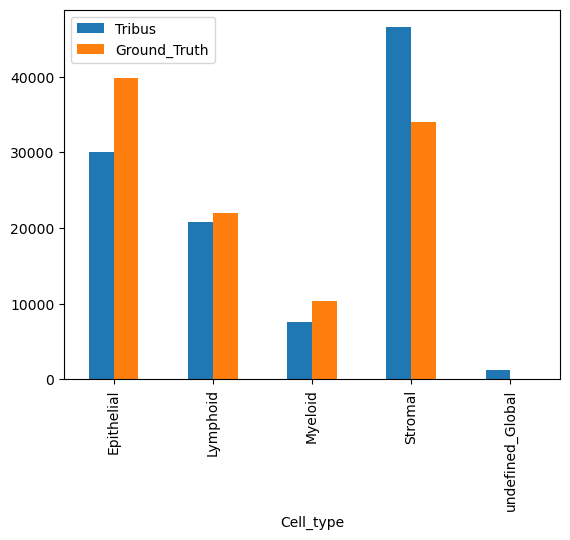

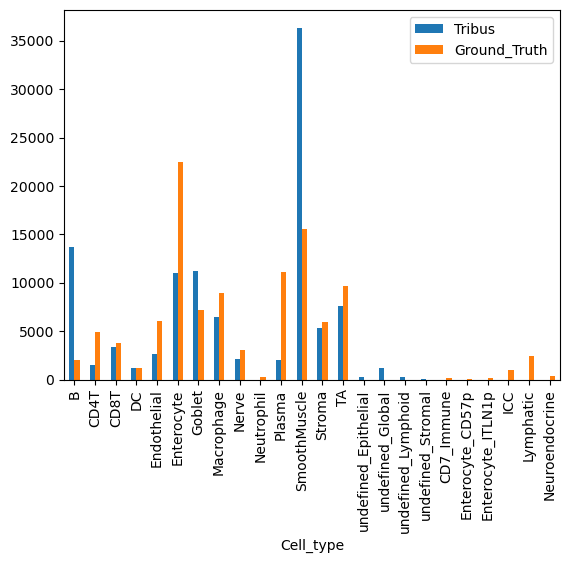

In [25]:
# cell_type_distribution(labels, level="Global")
cell_num_compare(list(sample_data["cell_type_upperlevel"]), list(labels["Global"]))
cell_num_compare(list(sample_data["cell_type_A"]), list(labels["final_label"]))

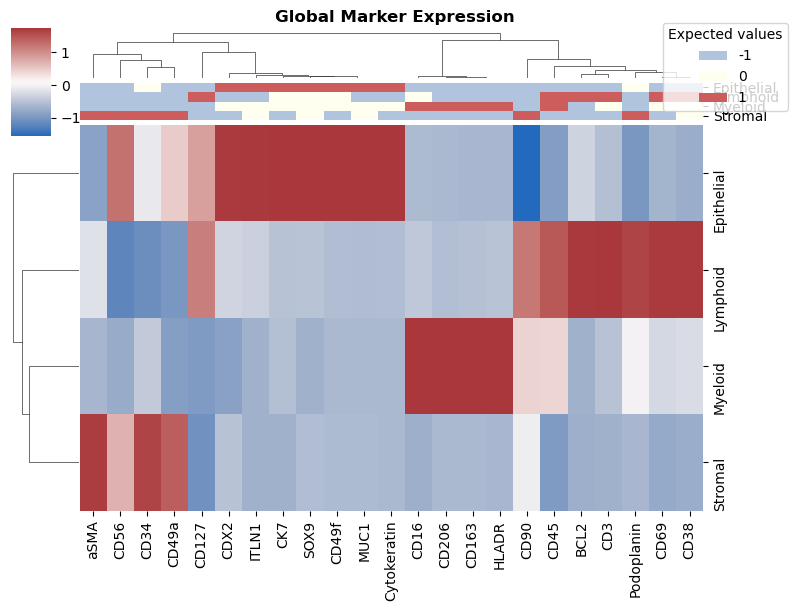

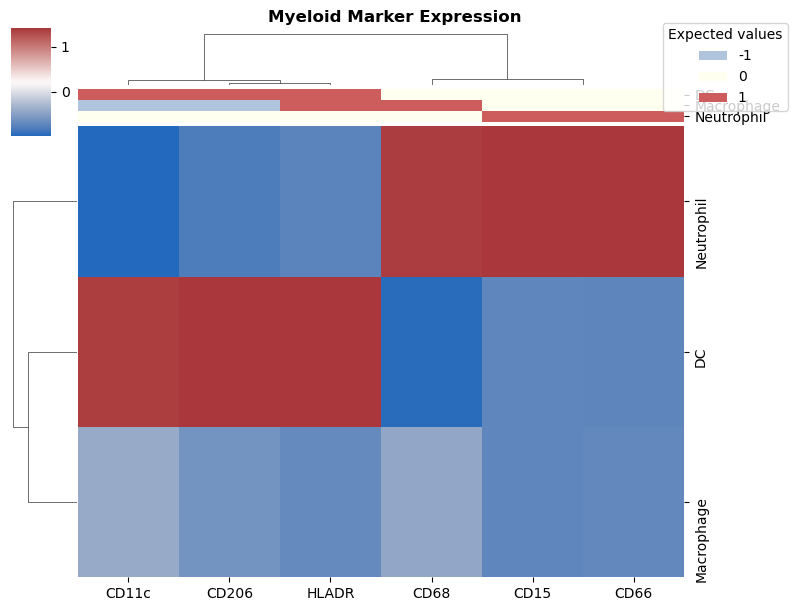

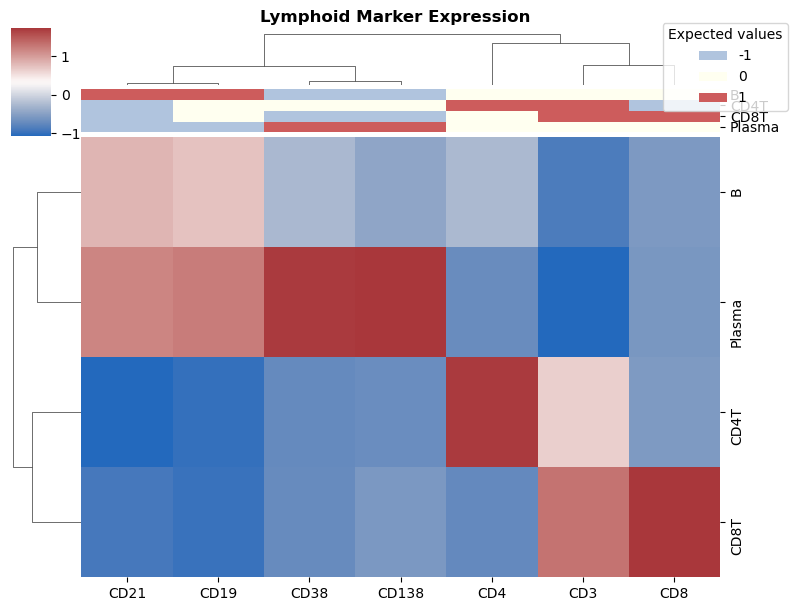

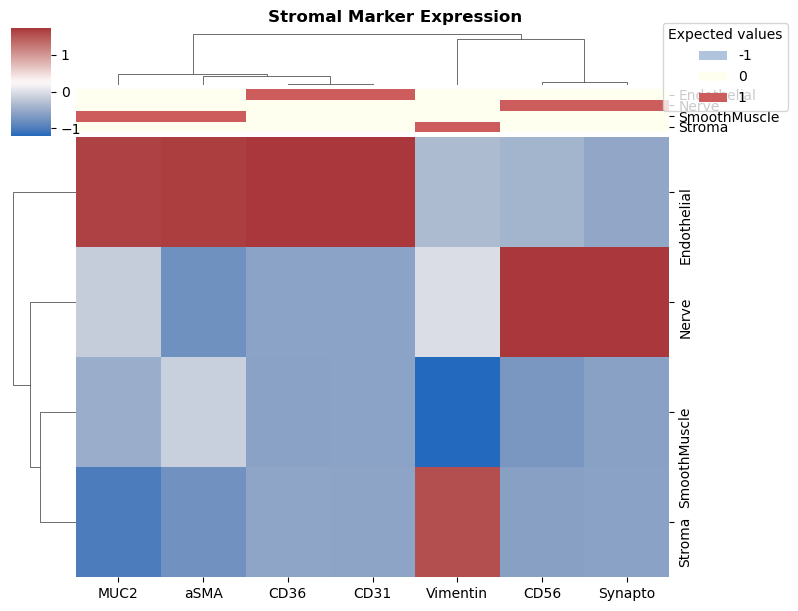

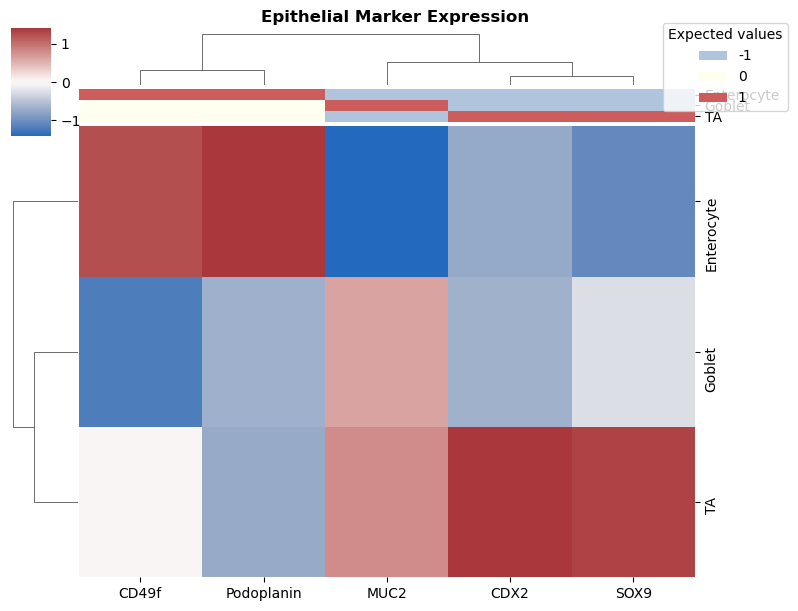

In [26]:
for i in labels.columns.values.tolist()[ : -1]: 
    heatmap_for_median_expression(sample_data, labels, logic, level=i, save=False,
                                    dpi='figure', transform=z_score, title="{} Marker Expression".format(i),
                                    c_palette=sns.color_palette(['lightsteelblue', 'ivory', 'indianred'], 3),
                                    cmap_='vlag', dendrogram_ratio_=0.1)

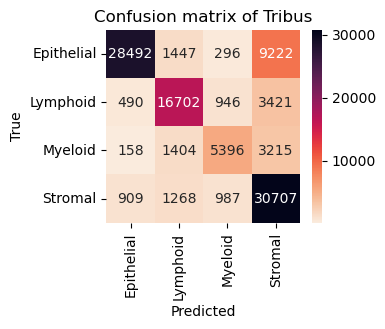

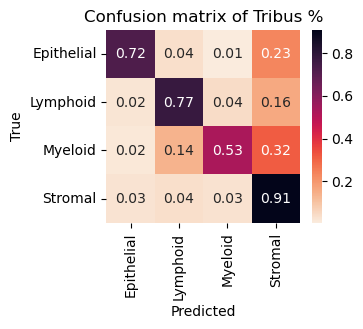

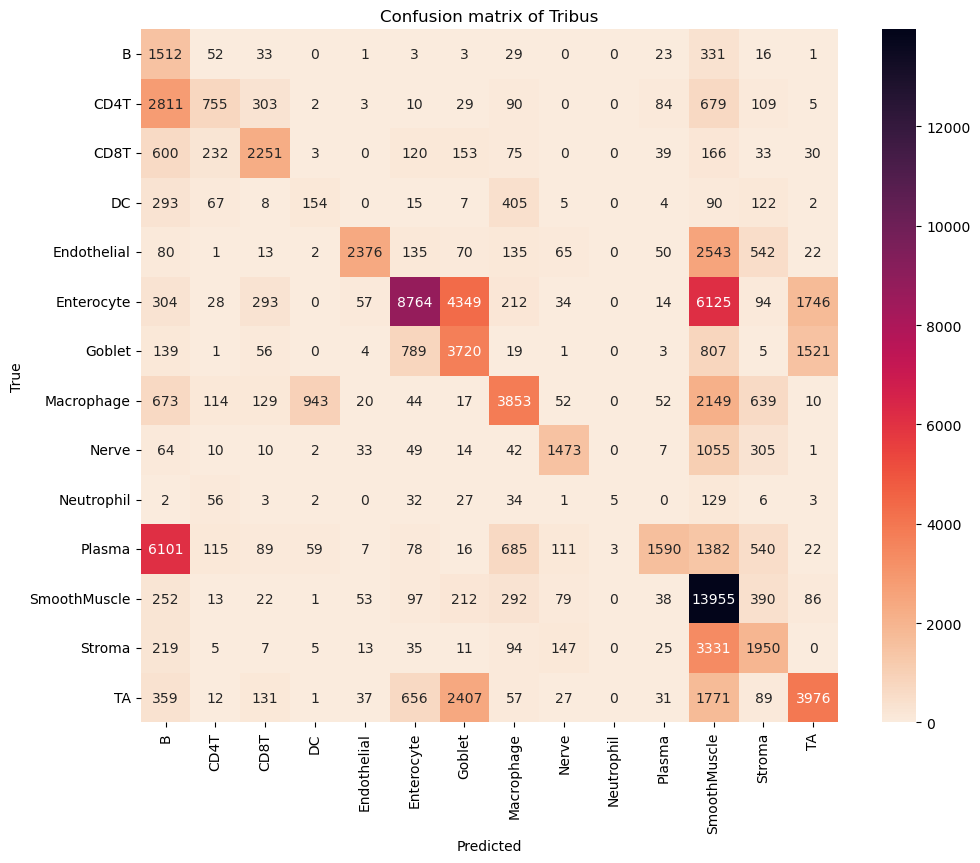

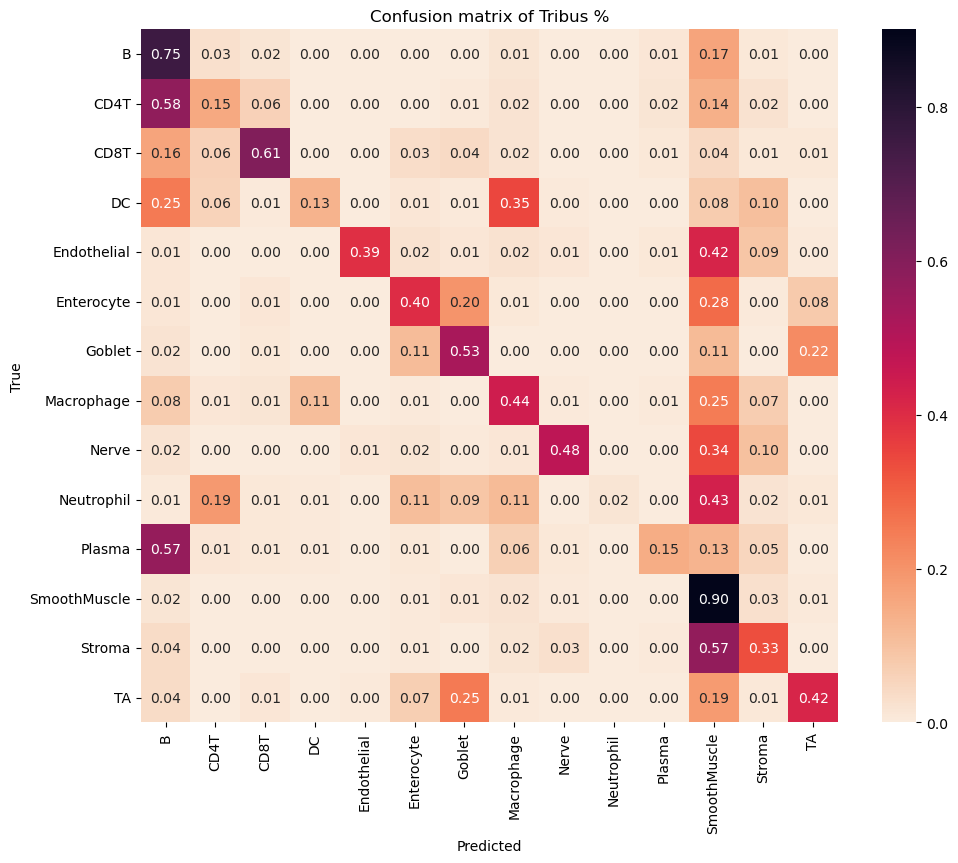

Rand score = 0.7744921395467003, Accuracy score = 0.7649034661849384, Precision score = 0.8019899653701521, F1 score = 0.7697235302317058


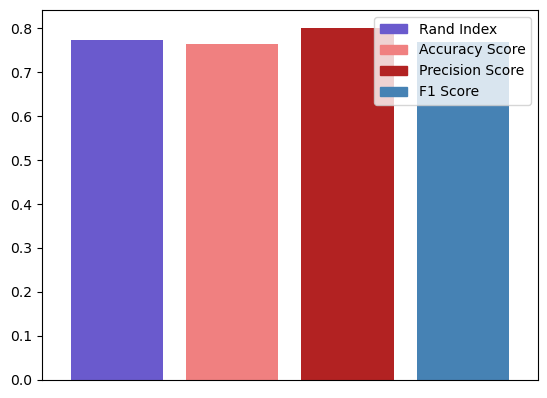

c:\Users\Localadmin_kangzigi\.conda\envs\tribus_new\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Rand score = 0.8082491837800864, Accuracy score = 0.4359452034172594, Precision score = 0.5727514179293636, F1 score = 0.4311540285146843


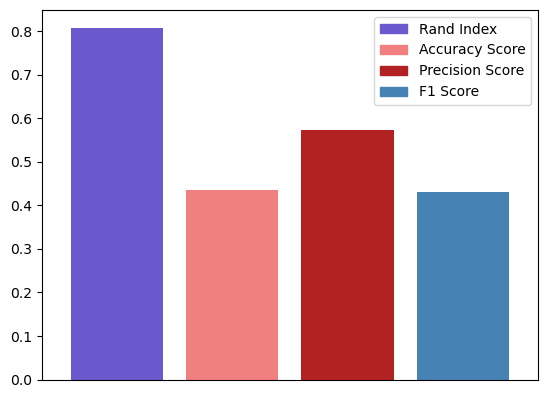

                  TN     FP     FN     TP  accuracy
B              92126  12153    493   1512  0.881017
CD4T          100583    760   4186    755  0.953464
CD8T          101406   1140   1487   2251  0.975283
DC            104075   1026   1029    154  0.980665
Endothelial    99943    256   3709   2376  0.962694
Enterocyte     81579   2244  13697   8764  0.850015
Goblet         91629   7512   3423   3720  0.897115
Macrophage     94785   2584   5062   3853  0.928061
Nerve         102517    683   1611   1473  0.978416
Neutrophil    105981      3    295      5  0.997196
Plasma         94796    383   9515   1590  0.906872
SmoothMuscle   68335  22415   1579  13955  0.774246
Stroma         96909   3417   4008   1950  0.930140
TA             92992   3582   5734   3976  0.912348
              precision    recall  f1-score   support
B              0.110648  0.754115  0.192980    2005.0
CD4T           0.498350  0.152803  0.233891    4941.0
CD8T           0.663816  0.602194  0.631505    3738.0
DC  

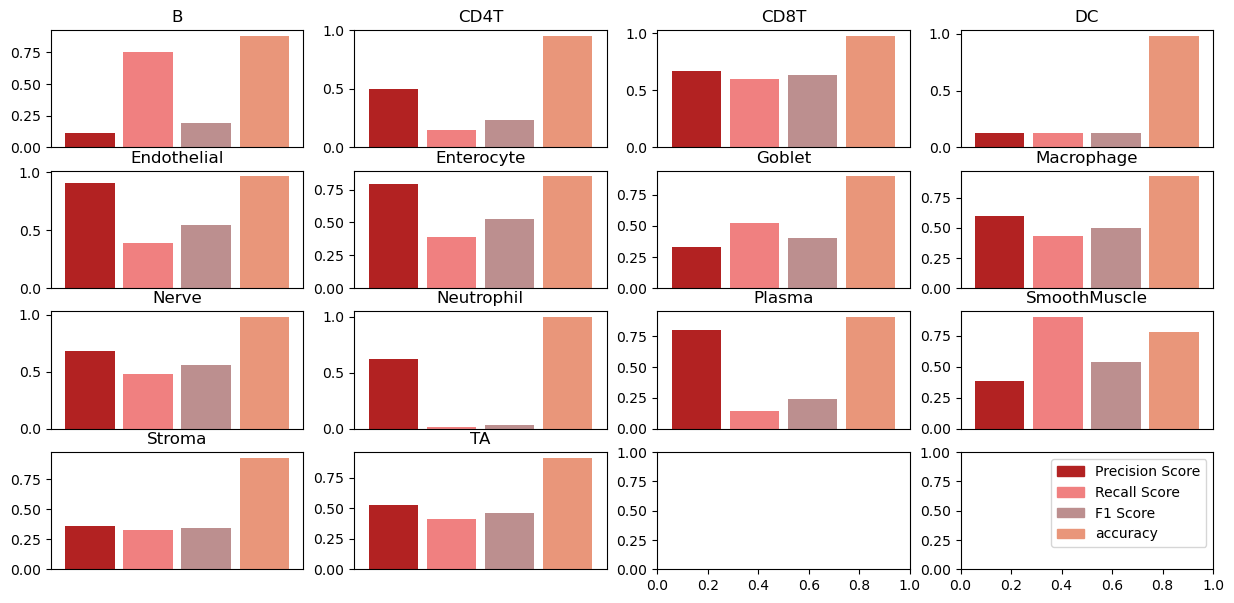

In [27]:
my_confusion_matrix(sample_data["cell_type_upperlevel"], labels["Global"])
my_confusion_matrix(sample_data["cell_type_A"], labels["final_label"])

cluster_metrics_overall(sample_data["cell_type_upperlevel"], labels["Global"])
cluster_metrics_overall(sample_data["cell_type_A"], labels["final_label"])

cluster_metrics_percelltype(sample_data["cell_type_A"], labels["final_label"])